<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

### <span style="color:red ">以下是我們後續輸出分析結果需要的方程式:
---    
    1. 每次你要輸出策略的績效結果時，下面這格你都要跑

In [1]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_closed = ''
    total_won =''
    total_lost =''
    win_streak = ''
    lose_streak = ''
    pnl_net =''
    strike_rate =''
    
    if len(analyzer.total)>2:
        total_closed = analyzer.total.closed
        total_won = analyzer.won.total
        total_lost = analyzer.lost.total
        win_streak = analyzer.streak.won.longest
        lose_streak = analyzer.streak.lost.longest
        pnl_net = round(analyzer.pnl.net.total,2)
    
    if total_closed:
        strike_rate=round((total_won / total_closed) * 100,2)
    else:
        strike_rate='沒有完整交易'
    print("策略運作分析結果:")
    print(f'獲利累積次數 : {str(total_won)}')
    print(f'損失累積次數 : {str(total_lost)}')
    print(f'獲利損失次數比 : {str(strike_rate)}')
    print(f'最高連續獲利交易次數 : {str(win_streak)}')
    print(f'最高連續損失交易次數 : {str(lose_streak)}')
    print(f'淨利結算 : {str(pnl_net)}')
    

## <span style="color:red "> 策略好不好，不是只看結果賺不賺，還有更多細節可以討論...
---

## <span style="color:red ">  <策略1-with Commision>以我們一開始的SMA簡單回測策略為例
---    
    我們測定策略如下:
    1.如果今天的收盤價高於20-day SMA，那我們就買進一張的股票。
    2.如果今天的收盤價低於20-day SMA，那我們就賣掉一張的股票。
    3.任何時候，我們手上最多就一張股票。
    
    

### <span style="color:red "><策略1.1- with Commision>導入需求模組

In [2]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2- with Commision>建立交易策略

In [23]:
class SmaStrategy(bt.Strategy):
    params = dict(
        ma_period=24,     
    )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)

### <span style="color:red "><策略1.3- with Commision>抓取目標股票的歷史資料

In [15]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-30',      #資料開始日期
                    end='2023-3-30',         #資料結束日期
                    progress=False
                 )
print(data)
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2022-03-30  599.0  600.0  597.0  600.0  586.768982  41230239
2022-03-31  602.0  602.0  594.0  597.0  583.835144  22700114
2022-04-01  585.0  589.0  584.0  589.0  576.011597  29732696
2022-04-06  578.0  580.0  575.0  578.0  565.254150  37645873
2022-04-07  571.0  573.0  566.0  566.0  553.518860  42904743
...           ...    ...    ...    ...         ...       ...
2023-03-22  524.0  533.0  524.0  533.0  533.000000  42385987
2023-03-23  528.0  539.0  528.0  538.0  538.000000  26728246
2023-03-24  536.0  539.0  535.0  539.0  539.000000  21926240
2023-03-27  533.0  536.0  531.0  531.0  531.000000  16111177
2023-03-28  525.0  530.0  524.0  525.0  525.000000  17234120

[243 rows x 6 columns]


### <span style="color:red "><策略1.4- with Commision>建立台股交易費用計算模式

In [24]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略1.5- with Commision>建立回測分析「大腦」

In [25]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(SmaStrategy)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略1.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [26]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {cerebro.broker.getvalue():.2f}')

2022-05-27, 開出買單 --- 當時市場價格: 530.00
2022-05-30, 買單執行 --- 買價: 538.00, 成本: 538000.00, 手續費: 459.99
2022-06-13, 開出賣單 --- 當時市場價格: 516.00
2022-06-14, 賣單執行 --- 賣價: 507.00, 成本: 538000.00, 手續費: 1954.49
2022-06-14, 運作結果 --- 獲利狀況: -31000.00, 淨獲利: -33414.47
2022-07-15, 開出買單 --- 當時市場價格: 492.50
2022-07-18, 買單執行 --- 買價: 495.50, 成本: 495500.00, 手續費: 423.65
2022-08-23, 開出賣單 --- 當時市場價格: 504.00
2022-08-24, 賣單執行 --- 賣價: 504.00, 成本: 495500.00, 手續費: 1942.92
2022-08-24, 運作結果 --- 獲利狀況: 8500.00, 淨獲利: 6133.43
2022-08-26, 開出買單 --- 當時市場價格: 512.00
2022-08-29, 買單執行 --- 買價: 497.00, 成本: 497000.00, 手續費: 424.94
2022-08-29, 開出賣單 --- 當時市場價格: 498.50
2022-08-30, 賣單執行 --- 賣價: 497.50, 成本: 497000.00, 手續費: 1917.86
2022-08-30, 運作結果 --- 獲利狀況: 500.00, 淨獲利: -1842.80
2022-11-08, 開出買單 --- 當時市場價格: 399.00
2022-11-09, 買單執行 --- 買價: 403.50, 成本: 403500.00, 手續費: 344.99
2022-12-12, 開出賣單 --- 當時市場價格: 475.00
2022-12-13, 賣單執行 --- 賣價: 473.00, 成本: 403500.00, 手續費: 1823.41
2022-12-13, 運作結果 --- 獲利狀況: 69500.00, 淨獲利: 67331.59
2023-01-09, 開出買單 --- 當時市場價

### <span style="color:red "><策略1.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


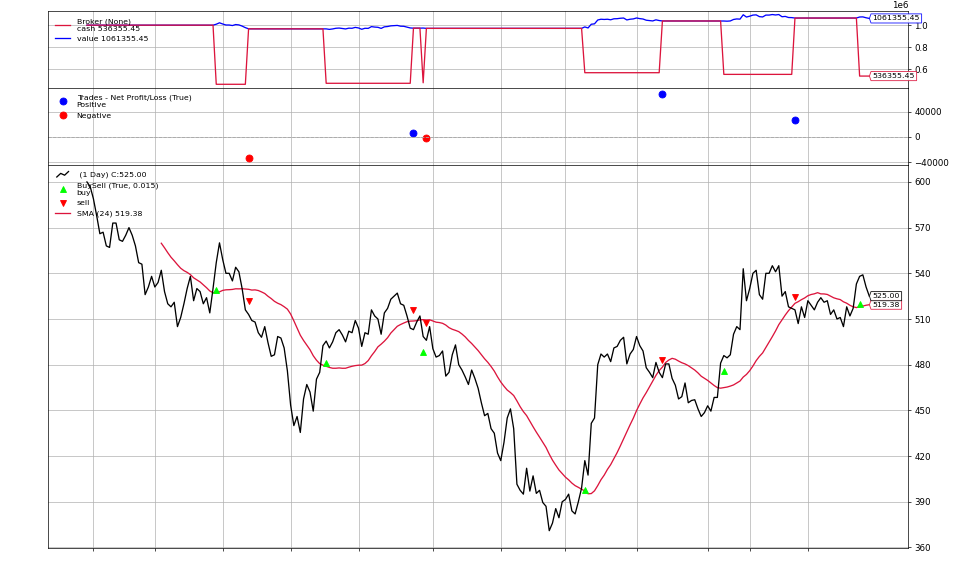

[[<Figure size 320x240 with 3 Axes>]]

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']=50
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略2- with Commision>我們不得不懷疑20-day SMA是一個好選擇嗎?
--------
    你有想過一個問題?幾日均線說穿了都是人說的一個故事。那既然是人定的，為何不讓機器來告訴我，屬於台積電的財富均線應該是幾日比較好呢?

### <span style="color:red "><策略2.2- with Commision>建立交易策略

In [20]:
class SmaStrategy(bt.Strategy):
   
    params = dict(
        ma_period=20,   
        totalValue=''
    )
    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell(size=1000)

    def stop(self):
        self.log(f'(SMA週期設定 = {self.params.ma_period:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()

### <span style="color:red "><策略2.4- with Commision>建立台股交易費用計算模式

In [21]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略2.5- with Commision>建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [22]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(SmaStrategy, ma_period=range(5, 61))
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")
opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'SMA週期設定:{strategy.params.ma_period}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-28, (SMA週期設定 =  5) --- 淨利數值: -169011.96
2023-03-28, (SMA週期設定 =  6) --- 淨利數值: -77882.18
2023-03-28, (SMA週期設定 =  7) --- 淨利數值: -55612.50
2023-03-28, (SMA週期設定 =  8) --- 淨利數值: -83751.75
2023-03-28, (SMA週期設定 =  9) --- 淨利數值: -28981.29
2023-03-28, (SMA週期設定 = 10) --- 淨利數值: -28035.82
2023-03-28, (SMA週期設定 = 11) --- 淨利數值: -739.38
2023-03-28, (SMA週期設定 = 12) --- 淨利數值: 35056.00
2023-03-28, (SMA週期設定 = 13) --- 淨利數值: 54093.54
2023-03-28, (SMA週期設定 = 14) --- 淨利數值: 54093.54
2023-03-28, (SMA週期設定 = 15) --- 淨利數值: 45826.52
2023-03-28, (SMA週期設定 = 16) --- 淨利數值: 32857.80
2023-03-28, (SMA週期設定 = 17) --- 淨利數值: 57594.36
2023-03-28, (SMA週期設定 = 18) --- 淨利數值: 66081.66
2023-03-28, (SMA週期設定 = 19) --- 淨利數值: 70036.79
2023-03-28, (SMA週期設定 = 20) --- 淨利數值: 80431.60
2023-03-28, (SMA週期設定 = 21) --- 淨利數值: 71418.07
2023-03-28, (SMA週期設定 = 22) --- 淨利數值: 73103.04
2023-03-28, (SMA週期設定 = 23) --- 淨利數值: 74099.18
2023-03-28, (SMA週期設定 = 24) --- 淨利數值: 61355.45
2023-03-28, (SMA週期設定 = 25) --- 淨利數值: 34183.96
2023-03-28, (SMA週期設定 = 26) -

### <span style="color:red "><策略3- with Commision>技術分析不是一直說什麼黃金交叉...什麼死亡交叉...
-----
    1.黃金交叉：短天期均線向上與長天期交叉，稱為黃金交叉。
    2.死亡交叉：短天期均線向下與長天期交叉，稱為死亡交叉。

### <span style="color:red "><策略3.2- with Commision>建立交易策略-5天和10天的黃金交叉

In [31]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=7,   # 短期均線週期
        pslow=17    # 長期均線週期
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        sma1 = bt.ind.SMA(self.datas[0],period=self.p.pfast)  # 短期均線
        sma2 = bt.ind.SMA(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.crossover < 0:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(SMA週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 最終資產價值: {self.broker.getvalue():.2f}')
        

### <span style="color:red "><策略3.4- with Commision>建立台股交易費用計算模式

In [32]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略3.5- with Commision>建立回測分析「大腦」

In [33]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

cerebro = bt.Cerebro()
# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)



### <span style="color:red "><策略3.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [34]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {firstStrat.broker.getvalue():.2f}')


2022-05-24, 開出買單 --- 當時市場價格: 520.00
2022-05-25, 買單執行 --- 買價: 522.00, 成本: 522000.00, 手續費: 148.77
2022-06-14, 開出賣單 --- 當時市場價格: 513.00
2022-06-15, 賣單執行 --- 賣價: 508.00, 成本: 522000.00, 手續費: 1668.78
2022-06-15, 運作結果 --- 獲利狀況: -14000.00, 淨獲利: -15817.55
2022-07-18, 開出買單 --- 當時市場價格: 495.50
2022-07-19, 買單執行 --- 買價: 487.50, 成本: 487500.00, 手續費: 138.94
2022-08-26, 開出賣單 --- 當時市場價格: 512.00
2022-08-29, 賣單執行 --- 賣價: 497.00, 成本: 487500.00, 手續費: 1632.64
2022-08-29, 運作結果 --- 獲利狀況: 9500.00, 淨獲利: 7728.42
2022-11-08, 開出買單 --- 當時市場價格: 399.00
2022-11-09, 買單執行 --- 買價: 403.50, 成本: 403500.00, 手續費: 115.00
2022-12-07, 開出賣單 --- 當時市場價格: 475.00
2022-12-08, 賣單執行 --- 賣價: 475.00, 成本: 403500.00, 手續費: 1560.38
2022-12-08, 運作結果 --- 獲利狀況: 71500.00, 淨獲利: 69824.63
2023-01-10, 開出買單 --- 當時市場價格: 486.00
2023-01-11, 買單執行 --- 買價: 487.00, 成本: 487000.00, 手續費: 138.80
2023-02-21, 開出賣單 --- 當時市場價格: 516.00
2023-02-22, 賣單執行 --- 賣價: 506.00, 成本: 487000.00, 手續費: 1662.21
2023-02-22, 運作結果 --- 獲利狀況: 19000.00, 淨獲利: 17198.99
2023-03-13, 開出買單 --- 當時市

### <span style="color:red "><策略3.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


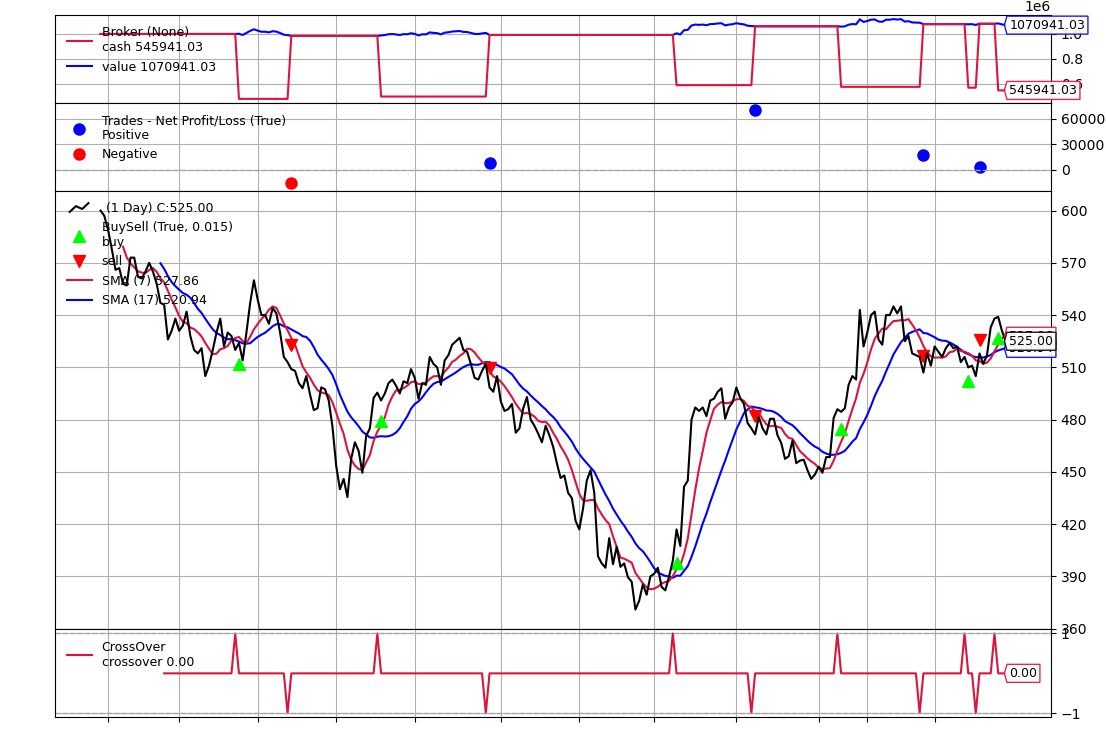

[[<Figure size 512x384 with 4 Axes>]]

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi']=80
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略4- with Commision>上面是5日線和10日線的交叉結果，那如果我想要知道哪兩條線的配對交叉結果最好...
-----
###     我就是想知道:
        到底是MA5穿過MA20比較厲害?
        還是MA20穿出MA60比較厲害?

### <span style="color:red "><策略4.2- with Commision>建立交易策略

In [28]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=5,   # 短期均線週期
        pslow=10,   # 長期均線週期
        totalValue=''
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        sma1 = bt.ind.SMA(self.datas[0],period=self.p.pfast)  # 短期均線
        sma2 = bt.ind.SMA(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.price = order.executed.price
                self.comm = order.executed.comm

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return


    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.crossover < 0:
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(SMA週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()

### <span style="color:red "><策略4.4- with Commision>建立台股交易費用計算模式

In [29]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略4.5- with Commision>建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [30]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

cerebro = bt.Cerebro()
cerebro.optstrategy(SmaCross, pfast=range(5,16),pslow=range(17,25))
cerebro.adddata(data)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")
opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'SMA短週期設定:{strategy.params.pfast} SMA長週期設定:{strategy.params.pslow}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-28, (SMA週期設定 = 短週期: 5,長週期:17) --- 淨利數值: 52987.26
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:18) --- 淨利數值: 57315.81
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:19) --- 淨利數值: 68318.94
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:20) --- 淨利數值: 60345.22
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:21) --- 淨利數值: 67719.25
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:22) --- 淨利數值: 64230.75
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:23) --- 淨利數值: 9215.08
2023-03-28, (SMA週期設定 = 短週期: 5,長週期:24) --- 淨利數值: -9751.07
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:17) --- 淨利數值: 61018.09
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:18) --- 淨利數值: 66311.23
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:19) --- 淨利數值: 37392.22
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:20) --- 淨利數值: 43899.43
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:21) --- 淨利數值: 29395.29
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:22) --- 淨利數值: 31757.19
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:23) --- 淨利數值: -1252.22
2023-03-28, (SMA週期設定 = 短週期: 6,長週期:24) --- 淨利數值: -2775.85
2023-03-28, (SMA週期設定 = 短週期: 7,長週期:17) --- 淨利數值: 70941.03
2023-03-28, (SMA週期設定 = 短週期: 7,長週